<a href="https://colab.research.google.com/github/Sajithpemarathna/Energy-Consumption-Data-in-Germany-1995-2020-/blob/main/Sector_Wise_Energy_Forecast_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.4273
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.3995
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.3813
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.3476
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.3201
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2937
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2576
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.2325
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1975
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1761
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.1624
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.1480
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1447
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1436
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1292
Epoch 1

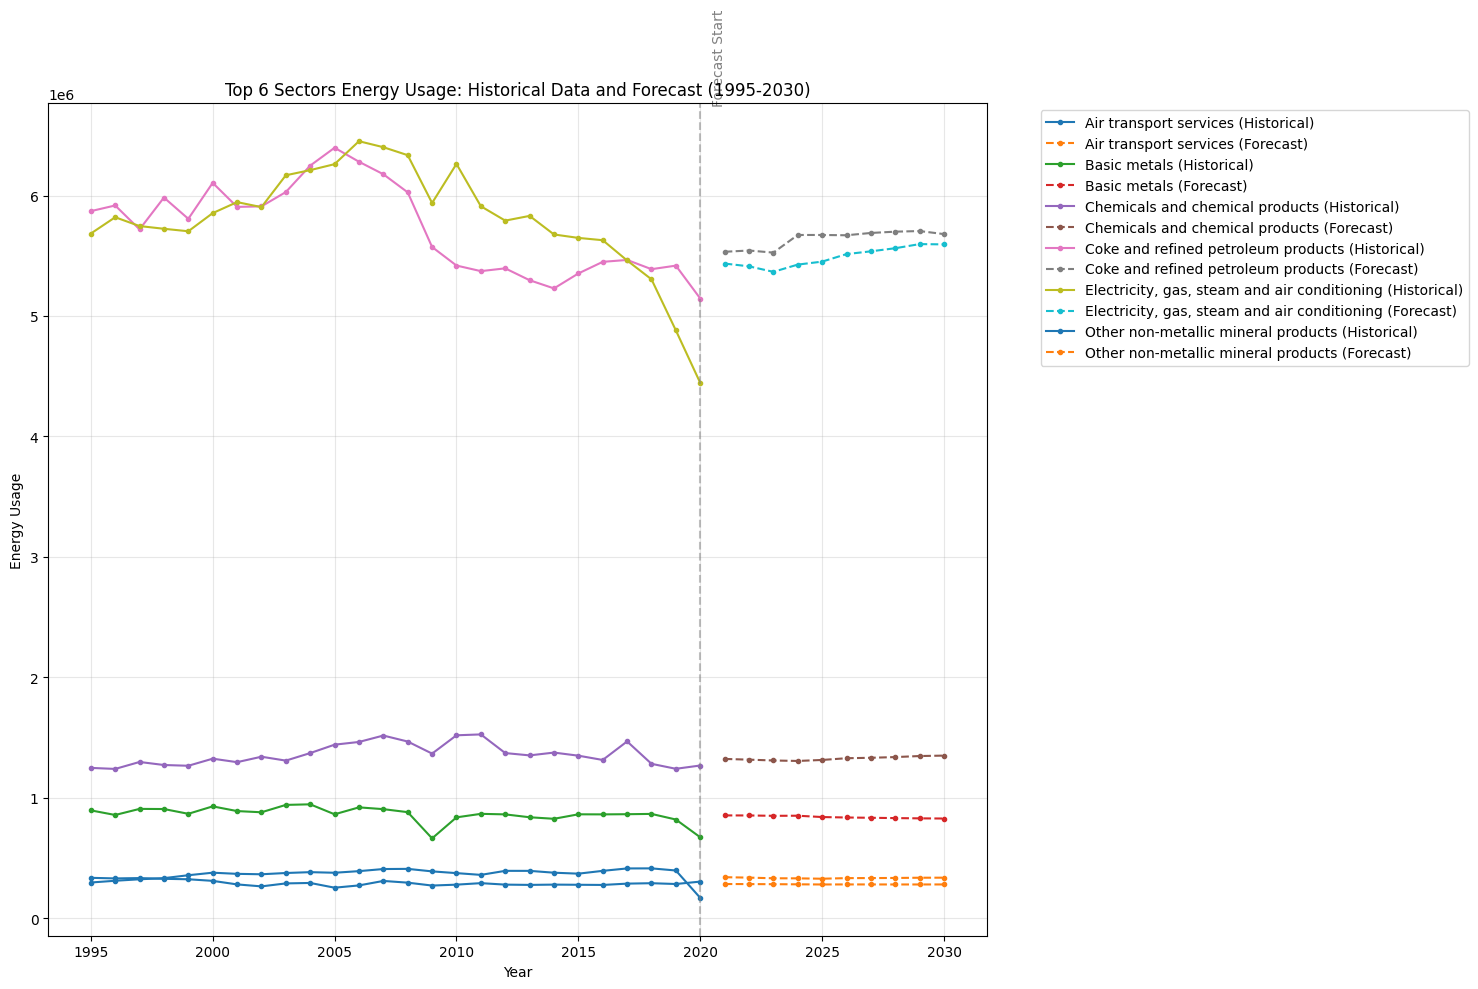


Forecasted values for 2021-2030:
Homogeneous Branches  Air transport services   Basic metals  \
2021                           341656.523801  854536.382813   
2022                           338145.287982  854101.457372   
2023                           332729.027110  851153.286851   
2024                           332067.304315  851959.847978   
2025                           329060.585944  840985.114798   
2026                           334002.996459  837233.499627   
2027                           334488.821585  834794.291936   
2028                           335311.546604  832291.255425   
2029                           337289.486315  830045.707307   
2030                           337748.251384  828741.571126   

Homogeneous Branches  Chemicals and chemical products  \
2021                                     1.323363e+06   
2022                                     1.317355e+06   
2023                                     1.310464e+06   
2024                                     1.3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Load and preprocess data
def load_data(file_path):
    df = pd.read_csv(file_path)
    # Group by sectors (Homogeneous Branches)
    df_melted = df.melt(id_vars=['Branch Code', 'Homogeneous Branches', 'Energy Carriers'],
                       var_name='Year', value_name='Energy_Usage')
    df_melted['Year'] = pd.to_numeric(df_melted['Year'])

    # Aggregate by sector
    sector_data = df_melted.groupby(['Year', 'Homogeneous Branches'])['Energy_Usage'].sum().reset_index()

    # Get top 6 sectors by total energy usage
    top_sectors = sector_data.groupby('Homogeneous Branches')['Energy_Usage'].sum()\
                            .sort_values(ascending=False).head(6).index

    # Filter for top sectors
    sector_data = sector_data[sector_data['Homogeneous Branches'].isin(top_sectors)]

    # Pivot to get sectors as columns
    df_pivot = sector_data.pivot(index='Year',
                                columns='Homogeneous Branches',
                                values='Energy_Usage')
    return df_pivot

# Step 2: Prepare sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, :])
    return np.array(X), np.array(y)

# Step 3: Build LSTM model
def build_model(input_shape, output_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(output_shape)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 4: Generate forecasts
def forecast_future(model, last_sequence, n_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))
        future_predictions.append(next_pred[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_pred[0]

    return scaler.inverse_transform(future_predictions)

# Step 5: Visualize results
def plot_forecasts(historical_data, forecast_data, sectors):
    plt.figure(figsize=(15, 10))

    for i, sector in enumerate(sectors):
        # Plot historical data
        plt.plot(historical_data.index, historical_data[sector],
                label=f'{sector} (Historical)', marker='o', markersize=3)

        # Plot forecast data
        plt.plot(forecast_data.index, forecast_data[sector],
                label=f'{sector} (Forecast)', linestyle='--', marker='o', markersize=3)

    plt.axvline(x=2020, color='gray', linestyle='--', alpha=0.5)
    plt.text(2020.5, plt.ylim()[1], 'Forecast Start', rotation=90, alpha=0.5)

    plt.title('Top 6 Sectors Energy Usage: Historical Data and Forecast (1995-2030)')
    plt.xlabel('Year')
    plt.ylabel('Energy Usage')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Step 6: Main execution
def main():
    # Load data
    file_path = "https://raw.githubusercontent.com/Sajithpemarathna/Energy-Consumption-Data-in-Germany-1995-2020-/refs/heads/main/Use%20of%20Energy%20of%20Energy%20Carriers.csv"
    data = load_data(file_path)

    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    seq_length = 5
    X, y = create_sequences(scaled_data, seq_length)

    # Train model
    model = build_model((seq_length, X.shape[2]), y.shape[1])
    model.fit(X, y, epochs=100, batch_size=32, verbose=1)

    # Generate forecasts
    n_future_steps = 10  # 2021-2030
    future_pred = forecast_future(model, X[-1], n_future_steps, scaler)

    # Create forecast DataFrame
    future_years = range(2021, 2031)
    forecast_df = pd.DataFrame(future_pred,
                             index=future_years,
                             columns=data.columns)

    # Visualize results
    plot_forecasts(data, forecast_df, data.columns)

    # Export results
    combined_data = pd.concat([data, forecast_df])
    combined_data.to_excel('sector_wise_forecast_1995_2030.xlsx')
    print("\nForecasted values for 2021-2030:")
    print(forecast_df)
    print("\nData exported to 'sector_wise_forecast_1995_2030.xlsx'")

if __name__ == "__main__":
    main()